In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as pd
import itertools
from pygem_eb.processing.plotting_fxns import *
from objectives import *

In [5]:
data_fp = '/home/claire/research/MB_data/Gulkana/Input_Gulkana_Glaciological_Data.csv'
path_out = '/home/claire/research/Output/calibration/09_18/'
plot_site = 'AB'
aa = [0.4,0.5,0.6]
kk = ['VanDusen','Sturm','Douville','Jansson','OstinAndersson']
winter_result = np.ones((3,len(aa),len(kk)))
summer_result = np.ones((3,len(aa),len(kk)))
site_avg_winter = np.ones((len(aa),len(kk)))
site_avg_summer = np.ones((len(aa),len(kk)))
label = []

for i,a_ice in enumerate(aa):
    for k,k_snow in enumerate(kk):
        print(f'ksnow: {k_snow}    aice: {a_ice}')
        label.append(f'{path_out}ksnow{k_snow}_aice{a_ice}_site{plot_site}_0.nc')
        for s,site in enumerate(['AB','B','D']):
            fn = label[-1]
            try:
                ds,startdate,enddate = getds(fn)
                winter,summer = seasonal_mass_balance(data_fp,ds,site=site,method='MAE')
                winter_result[s,i,k] = winter
                summer_result[s,i,k] = summer
            except:
                winter_result[s,i,k] = np.nan
                summer_result[s,i,k] = np.nan
                print(site+' does not exist')
        site_avg_winter[i,k] = np.mean(winter_result[:,i,k])
        site_avg_summer[i,k] = np.mean(summer_result[:,i,k])
best_winter = np.argmin(site_avg_winter)
best_summer = np.argmin(site_avg_summer)

print(f'Best winter run for was '+label[best_winter])
print(f'Best summer run for was '+label[best_summer])

# ds = xr.open_dataset(label[best_summer])
# fig,ax = seasonal_mass_balance(data_fp,ds,site=plot_site,plot=True)
# fig.suptitle(f'Best summer run between all sites, at site {plot_site}')
# plt.savefig(f'/home/claire/research/Output/calibration/best_summer_{plot_site}.png',dpi=200)

# ds = xr.open_dataset(label[best_winter])
# fig,ax = seasonal_mass_balance(data_fp,ds,site=plot_site,plot=True)
# fig.suptitle(f'Best winter run between all sites, at site {plot_site}')
# plt.savefig(f'/home/claire/research/Output/calibration/best_winter_{plot_site}.png',dpi=200)

       ksnow: VanDusen    aice: 0.4
       ksnow: Sturm    aice: 0.4
       ksnow: Douville    aice: 0.4
       ksnow: Jansson    aice: 0.4
       ksnow: OstinAndersson    aice: 0.4
       ksnow: VanDusen    aice: 0.5
       ksnow: Sturm    aice: 0.5
       ksnow: Douville    aice: 0.5
       ksnow: Jansson    aice: 0.5
       ksnow: OstinAndersson    aice: 0.5
       ksnow: VanDusen    aice: 0.6
       ksnow: Sturm    aice: 0.6
       ksnow: Douville    aice: 0.6
       ksnow: Jansson    aice: 0.6
       ksnow: OstinAndersson    aice: 0.6
Best winter run for was /home/claire/research/Output/calibration/09_18/ksnowSturm_aice0.6_siteAB_0.nc
Best summer run for was /home/claire/research/Output/calibration/09_18/ksnowSturm_aice0.6_siteAB_0.nc


In [26]:
def grid_plot(params_dict,result_summer,result_winter):
    """
    Parameters
    ----------
    params_dict : dict
        dict formatted as 'param_name':[option_1,option_2,...]
    result_summer and reuslt_winter : np.array
        should be size (N1xN2x...Nn) where:
            n is the number of param sets
            N is the number of options in each set
    """
    # Parse parameters
    param_names = list(params_dict.keys())
    combos = list(itertools.combinations(param_names,2))
    n_combos = len(combos)
    mid_idx = n_combos / 2
    if mid_idx % 1 != 0:
        mid_idx = int(mid_idx)

    # Create plot
    fig = plt.figure(figsize=(3*n_combos, 5))
    gs = fig.add_gridspec(2,n_combos, wspace=0.3,hspace=0.5)

    # Normalize RMSE values across all three plots for shared colorbar
    all_summer = result_summer[~np.isnan(result_summer)].flatten()
    all_winter = result_winter[~np.isnan(result_winter)].flatten()
    norm_summer = plt.Normalize(vmin=np.min(all_summer), vmax=np.max(all_summer))
    norm_winter = plt.Normalize(vmin=np.min(all_winter), vmax=np.max(all_winter))
    cmap = 'viridis_r'

    # Create the scatter plots
    for j,pair in enumerate(combos):
        param_1 = params_dict[pair[0]]
        param_2 = params_dict[pair[1]]
        if type(param_2[0]) == str:
            param_2 = np.arange(len(param_2))
        x,y = np.meshgrid(param_1,param_2)
        for i,season in enumerate(['summer','winter']):
            ax = fig.add_subplot(gs[i,j])
            if j == 0:
                ax.text(-0.3,0.5,f'{season} loss',fontsize=14,ha='center', va='center', rotation='vertical', transform=ax.transAxes)
            slices = [slice(None)] * n_combos
            slices[j] = mid_idx
            if season == 'winter':
                result = winter_result[tuple(slices)]
                norm = norm_winter
            if season == 'summer':
                result = summer_result[tuple(slices)]
                norm = norm_summer
            print(result)
            ax.scatter(x,y,c=result,cmap=cmap,s=500,norm=norm)
            ax.set_xlabel(pair[0],fontsize=12)
            ax.set_ylabel(pair[1],fontsize=12)
            ax.set_xticks(param_1)
            ax.set_yticks(param_2)
            ax.grid(True)

    # Add colorbars to each row
    axes = np.array(fig.get_axes()).reshape(2,n_combos)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_summer, cmap=cmap), ax=axes[0,:], orientation='vertical')
    cbar.set_label('MAE')

    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_winter, cmap=cmap),ax=axes[1,:], orientation='vertical')
    cbar.set_label('MAE')


In [40]:
plot_site = 'D'
ds1 ,startdate,enddate = getds(label[best_winter].replace('AB',plot_site))
ds = xr.open_dataset(label[best_winter].replace('AB','D'))
# seasonal_mass_balance(data_fp,ds,plot_site,plot=True)
# compare_runs(dslist,['2000-04-01',enddate],['one','two'],'melt',res='6MS')
# np.all(ds.melt.values == ds1.melt.values)

True

[0]
[[0.52684052 0.56232471 0.52374197 0.59272025 0.53010471]
 [0.52684052 0.56232471 0.59366852 0.52714201 0.53010471]
 [0.57966242 0.60507463 0.52374197 0.52714201 0.53010471]]
[0]
[[0.15109843 0.1484755  0.15116163 0.1688451  0.15123121]
 [0.15109843 0.1484755  0.16839524 0.15125487 0.15123121]
 [0.16901609 0.1699445  0.15116163 0.15125487 0.15123121]]


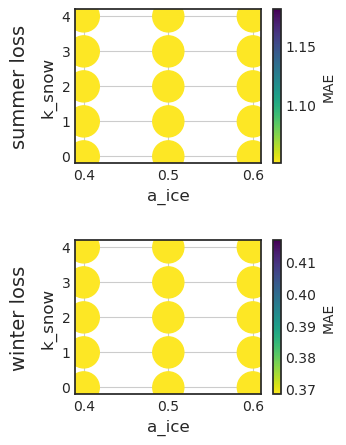

In [27]:
params_dict = {'a_ice':[0.4,0.5,0.6],
               'k_snow':["VanDusen","Sturm","Douville","Jansson","OstinAndersson"]}
grid_plot(params_dict,site_avg_summer,site_avg_winter)

In [84]:
def plot_by(ds,time,vars,t='Monthly EB Outputs',by='month'):
    h = 1.5
    fig,axes = plt.subplots(len(vars),1,figsize=(7,h*len(vars)),sharex=True,layout='constrained')
    if len(vars) == 1:
        axes = [axes]
    
    if by == 'month':
        ds[by] = (['time'],pd.to_datetime(ds['time'].values).month)
        time_list = np.arange(1,13)
    elif by == 'hour':
        ds[by] = (['time'],pd.to_datetime(ds['time'].values).hour)
        time_list = np.arange(0,24)
    elif by == 'doy':
        ds[by] = (['time'],pd.to_datetime(ds['time'].values).day_of_year)
        time_list = np.arange(1,366)
        running_sum = 0

    if len(time) == 2:
        start = pd.to_datetime(time[0])
        end = pd.to_datetime(time[1])
        time = pd.date_range(start,end,freq='h')
    ds = ds.sel(time=time)
    c_iter = iter([plt.cm.Dark2(i) for i in range(8)])
    for i,v in enumerate(vars):
        axis = axes[i]
        vararray = np.array(v)
        for var in vararray:
            try:
                c = next(c_iter)
            except:
                c_iter = iter([plt.cm.Dark2(i) for i in range(8)])
                c = next(c_iter)
        
            var_out = []
            for time in time_list:
                ds_sel = ds.where(ds[by] == time,drop=True)
                if 'layer' in var:
                    vardata = ds_sel.isel(layer=0)[var].to_numpy()
                else:
                    vardata = ds_sel[var].to_numpy()
                if by == 'doy':
                    nyrs = int(vardata.shape[0] / 24)
                    try:
                        vardata = np.mean(vardata.reshape(24,nyrs),axis=0)
                    except:
                        if time != 366:
                            print('Must index dates exactly 1 year - 1 day apart')
                        vardata = np.array([0])
                    out = np.mean(vardata)
                else:
                    out = np.mean(vardata)
                var_out.append(out)
            axis.plot(time_list,var_out,label=var,color=c)
            axis.legend()
            if by == 'doy':
                axis.axvline(111,color='green')
                axis.axvline(294,color='red')
    if by == 'month':
        months = pd.date_range('2024-01-01','2024-12-31',freq='MS')
        month_names = [date.month_name()[:3] for date in months]
        axis.set_xticks(np.arange(1,13),month_names)
    if by == 'doy':
        axis.set_xlabel('Day of year')
    axis.set_ylabel('Melt (mm w.e.)')
    axis.tick_params(length=5)
    fig.suptitle(t)

In [87]:
ds = xr.open_dataset('/home/claire/research/Output/EB_local/run_2023_06_20_hourly_00.nc')
ds

<xarray.Dataset>
Dimensions:      (time: 52585, bin: 3, layer: 20)
Coordinates:
  * time         (time) datetime64[ns] 1980-04-01 ... 1986-04-01
  * bin          (bin) int64 0 1 2
  * layer        (layer) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables: (12/19)
    SWin         (time, bin) float64 ...
    SWout        (time, bin) float64 ...
    LWin         (time, bin) float64 ...
    LWout        (time, bin) float64 ...
    rain         (time, bin) float64 ...
    sensible     (time, bin) float64 ...
    ...           ...
    surftemp     (time, bin) float64 ...
    snowtemp     (time, bin, layer) float64 ...
    watercont    (time, bin, layer) float64 ...
    layerheight  (time, bin, layer) float64 ...
    snowdensity  (time, bin, layer) float64 ...
    snowdepth    (time, bin) float64 ...

Must index dates exactly 1 year - 1 day apart


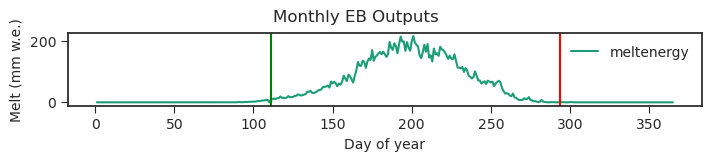

In [85]:
ds = xr.open_dataset('/home/claire/research/Output/calibration/09_18/ksnowDouville_aice0.4_siteAB_0.nc')
ds.melt.values *= 1000
plot_by(ds,[startdate,'2022-04-20'],[['meltenergy']],by='doy')

In [ ]:
ds.melt.values *= 1000
plot_by(ds,0,[startdate,enddate],[['melt']],by='doy')